## Importações

O que falta realizar:
- [ ] Features Simples
- [X] Análise de importância de features
- [ ] Testar outros métodos de calibração de curva
- [ ] Melhorar a estrutura do código para entregável

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, brier_score_loss

In [2]:
voronoi = pd.read_csv("features_voronoi.csv", index_col=0)
interception_events = pd.read_csv("interception_events_old.csv", index_col=0)

In [3]:
# Eliminado pass_high_point_type, deixando somente Ground e Below Waist
# interception_events = interception_events[(interception_events["pass_high_point_type"] == "G") | (interception_events["pass_high_point_type"] == "L")]

# # Eliminando pass_type, deixando somente Simple Pass and Create Contest
# interception_events = interception_events[(interception_events["pass_type"] == "S") | (interception_events["pass_type"] == "C")]

In [4]:
df = interception_events.reset_index().merge(voronoi, left_on="index", right_on="instance_index").drop("index", axis=1)

In [5]:
df.loc[:, "pass_outcome_type"] = df["pass_outcome_type"].str.replace("B", "D")
df = df[~((df["pass_outcome_type"] == "O") | (df["pass_outcome_type"] == "S"))]
df["Y"] = (df["pass_outcome_type"] == "D").astype(int)

In [6]:
df_voronoi = df[list(voronoi.columns) + ["Y"]].drop("instance_index", axis=1).reset_index(drop=True)

In [7]:
# boxplots

## Pré-Processamento

In [8]:
X = pd.get_dummies(df_voronoi, columns=["adversary_domain_pass_count"]).drop(["Y"], axis=1)
y = df_voronoi["Y"]

In [9]:
dummy_columns = list(set(X.columns) - set(df_voronoi.columns))
not_dummy_columns = list(set(X.columns) - set(dummy_columns))

for col in dummy_columns:
    X[col] = X[col].astype(int)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Modelos

In [11]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [12]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, max_features="sqrt"),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', sample_weight=classes_weights),
}

In [13]:
results = []

for name, model in models.items():
    print(f"Evaluando {name}..")

    model.fit(X_train, y_train)
    
    y_prob = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, model.predict(X_test))
    roc_auc = roc_auc_score(y_test, y_prob)
    brier_score = brier_score_loss(y_test, y_prob)
    
    results.append({
      "name": name,
      "accuracy": accuracy,
      "roc_auc": roc_auc,
      "brier_score": brier_score,
      "y_prob": y_prob,
      "model": model
    })

Evaluando Random Forest..
Evaluando XGBoost..


C:\Users\tonim\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:55:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sample_weight" } are not used.

  warnings.warn(smsg, UserWarning)


In [41]:
np.mean([brier_score_loss(y_test, np.random.random(len(y_test)) > 1-y_train.mean()) for _ in range(1000)])

0.2653554781676935

In [47]:
pd.DataFrame(results)

,name,accuracy,roc_auc,brier_score,y_prob,model
0,Random Forest,0.849719,0.786991,0.112009,"[0.56, 0.19, 0.73, 0.11, 0.2, 0.01, 0.23, 0.0,...","(DecisionTreeClassifier(max_features='sqrt', r..."
1,XGBoost,0.843022,0.783783,0.115972,"[0.57298684, 0.17012596, 0.86176807, 0.0999867...","XGBClassifier(base_score=None, booster=None, c..."


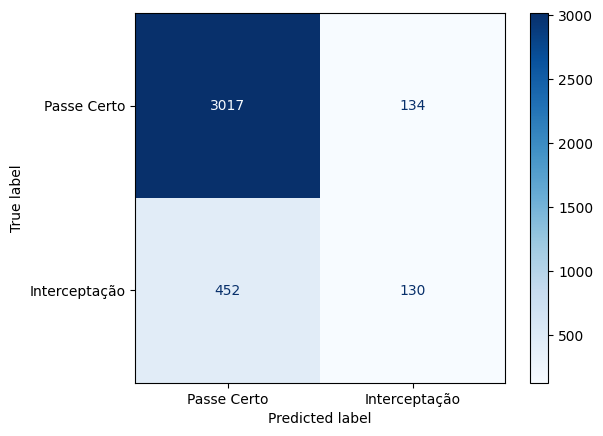

In [48]:
cm = confusion_matrix(y_test, results[1]["model"].predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Passe Certo', 'Interceptação'])
disp.plot(cmap='Blues', values_format='d')

## Feature Importance para modelos Random Forest

### Mean Decreasing Impurity

Quanto maior a redução da impureza, mais importante a feature é. Somente para modelos de árvore.

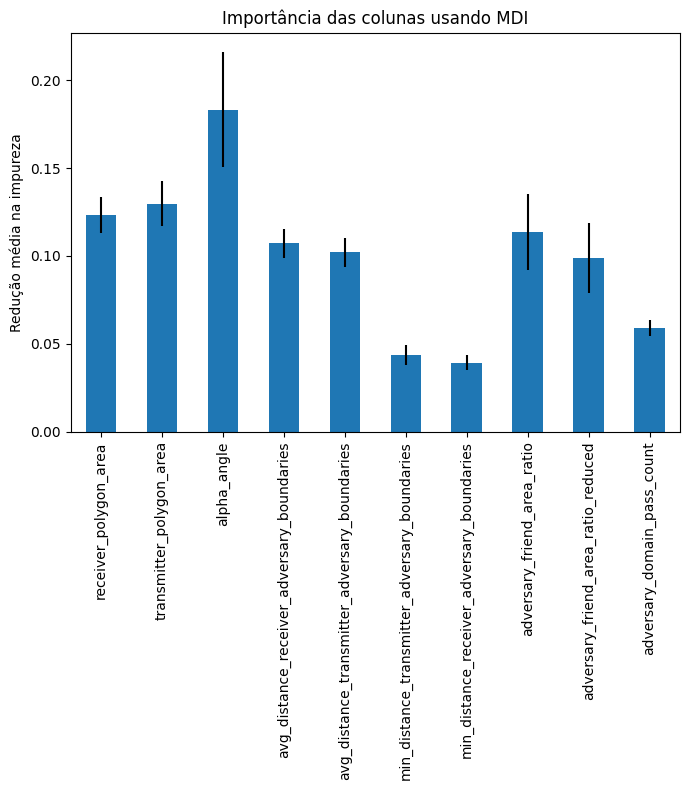

In [49]:
forest = results[0]["model"]
labels = list(X_test.columns)[:-len(dummy_columns)] + [dummy_columns[0][:-2]]

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

std_dummy = np.mean(std[-len(dummy_columns):])
forest_importance_dummy = importances[-len(dummy_columns):].sum()

std = list(std[:-len(dummy_columns)]) + [std_dummy]
importances = list(importances[:-len(dummy_columns)]) + [forest_importance_dummy]

forest_importances = pd.Series(importances, index=labels)
fig, ax = plt.subplots(figsize=(7, 8))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Importância das colunas usando MDI")
ax.set_ylabel("Redução média na impureza")
fig.tight_layout()
plt.show()

### Drop Columns

Dropa cada coluna e verifica seu impacto.

In [ ]:
from tqdm import tqdm
from sklearn.base import clone

forest_clone = clone(forest)
forest_clone.random_state = 42
forest_clone.set_params(warm_start=True, 
          oob_score=True)

forest_clone.fit(X_train, y_train)

benchmark_score = forest_clone.oob_score_

importances = []

for column in tqdm(X_train.columns):
    forest_clone = clone(forest)
    forest_clone.random_state = 42
    forest_clone.set_params(warm_start=True, 
              oob_score=True)

    forest_clone.fit(X_train.drop(column, axis=1), y_train)
    drop_score = forest_clone.oob_score_
    importances.append(benchmark_score - drop_score)

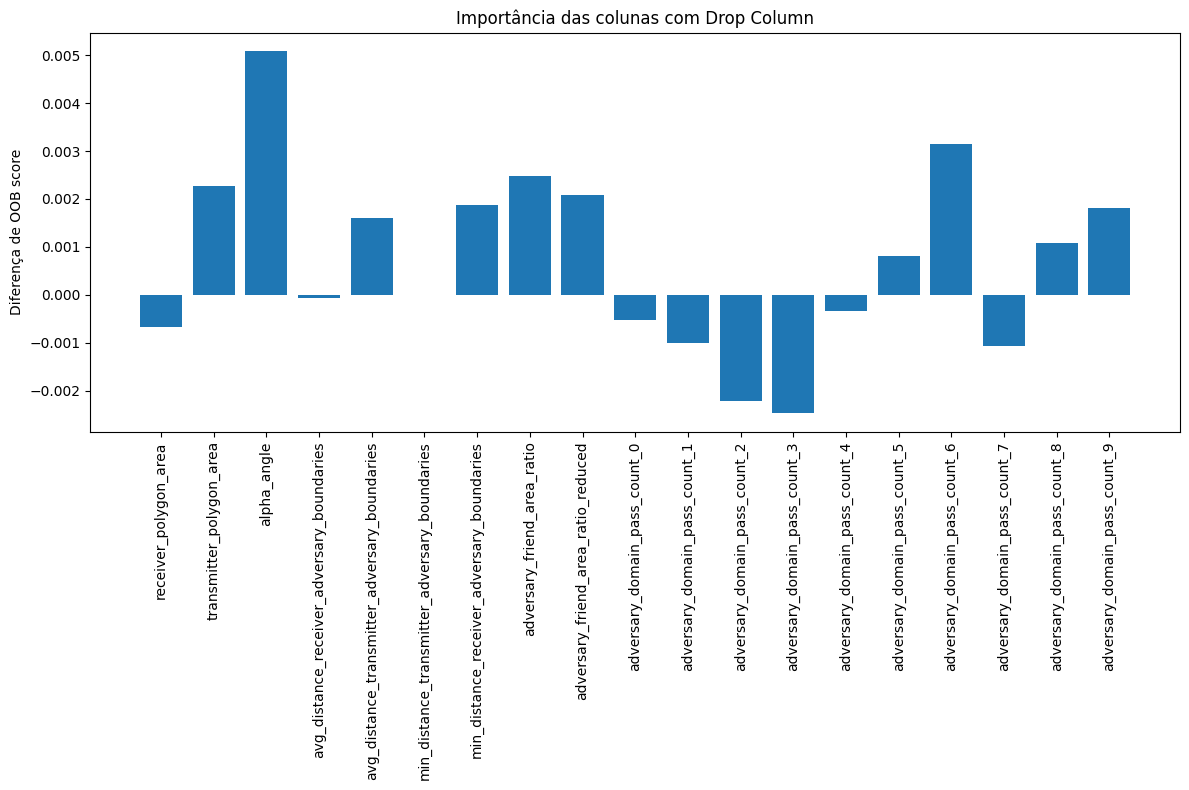

In [34]:
labels = list(X_train.columns)

fig, ax = plt.subplots(figsize=(12, 8))
plt.bar(x=labels, height=importances)
ax.set_title(f"Importância das colunas com Drop Column")
ax.set_ylabel("Diferença de OOB score")
plt.xticks(rotation='vertical')
fig.tight_layout()
plt.show()

## Curva de calibração

In [15]:
forest = results[0]["model"]
predict_proba = forest.predict_proba(X_test)[:, 1]

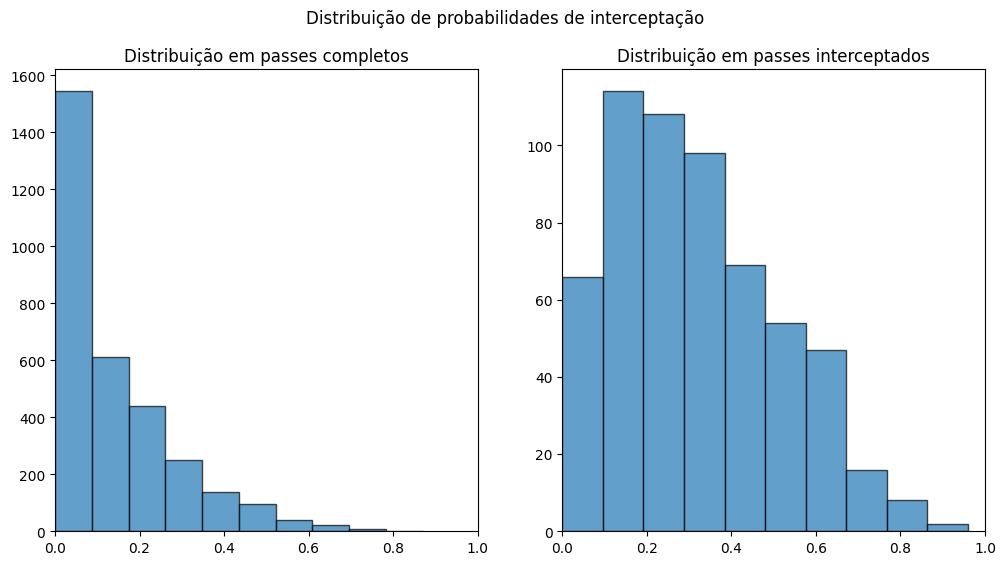

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(predict_proba[y_test == 0.0], edgecolor='black', alpha=0.7)
ax[0].set_title("Distribuição em passes completos")
ax[0].set_xlim(0, 1)

ax[1].hist(predict_proba[y_test == 1.0], edgecolor='black', alpha=0.7)
ax[1].set_title("Distribuição em passes interceptados")
ax[1].set_xlim(0, 1)

plt.suptitle("Distribuição de probabilidades de interceptação")
plt.show()

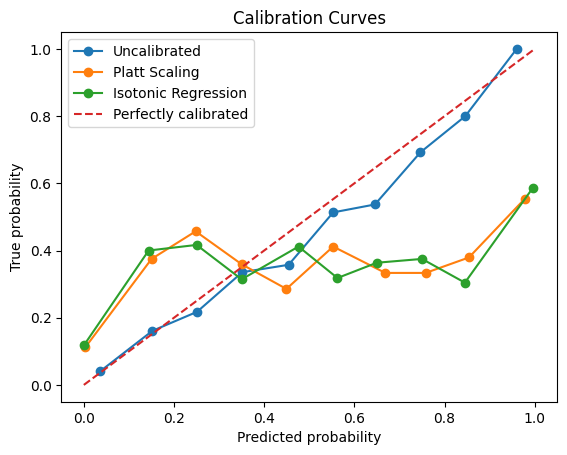

In [17]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

calibrated_model_platt = CalibratedClassifierCV(forest, method='sigmoid', cv='prefit')
calibrated_model_platt.fit(X_train, y_train)

calibrated_model_isotonic = CalibratedClassifierCV(forest, method='isotonic', cv='prefit')
calibrated_model_isotonic.fit(X_train, y_train)

y_prob_platt = calibrated_model_platt.predict_proba(X_test)[:, 1]
y_prob_isotonic = calibrated_model_isotonic.predict_proba(X_test)[:, 1]

prob_true, prob_pred = calibration_curve(y_test, predict_proba, n_bins=10)
prob_true_platt, prob_pred_platt = calibration_curve(y_test, y_prob_platt, n_bins=10)
prob_true_isotonic, prob_pred_isotonic = calibration_curve(y_test, y_prob_isotonic, n_bins=10)

# Plot the calibration curves
plt.plot(prob_pred, prob_true, marker='o', label='Uncalibrated')
plt.plot(prob_pred_platt, prob_true_platt, marker='o', label='Platt Scaling')
plt.plot(prob_pred_isotonic, prob_true_isotonic, marker='o', label='Isotonic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration Curves')
plt.legend()
plt.show()

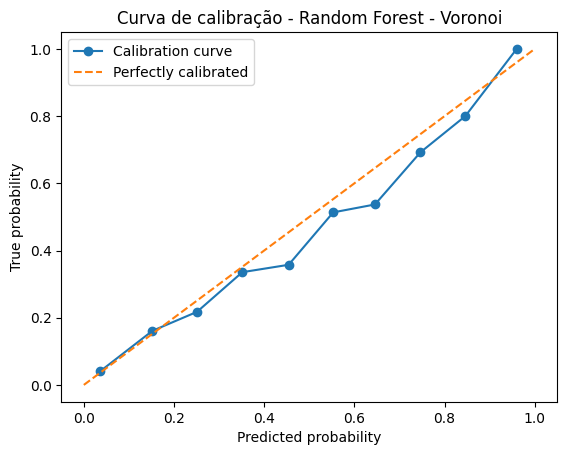

In [18]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

prob_true, prob_pred = calibration_curve(y_test, predict_proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Curva de calibração - Random Forest - Voronoi')
plt.legend()
plt.show()